In [1]:
import os
from torch_snippets import *

In [9]:
classIds = pd.read_csv('./signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}
id2int

{'Speed limit (20km/h)': 0,
 'Speed limit (30km/h)': 1,
 'Speed limit (50km/h)': 2,
 'Speed limit (60km/h)': 3,
 'Speed limit (70km/h)': 4,
 'Speed limit (80km/h)': 5,
 'End of speed limit (80km/h)': 6,
 'Speed limit (100km/h)': 7,
 'Speed limit (120km/h)': 8,
 'No passing': 9,
 'No passing for vechiles over 3.5 metric tons': 10,
 'Right-of-way at the next intersection': 11,
 'Priority road': 12,
 'Yield': 13,
 'Stop': 14,
 'No vechiles': 15,
 'Vechiles over 3.5 metric tons prohibited': 16,
 'No entry': 17,
 'General caution': 18,
 'Dangerous curve to the left': 19,
 'Dangerous curve to the right': 20,
 'Double curve': 21,
 'Bumpy road': 22,
 'Slippery road': 23,
 'Road narrows on the right': 24,
 'Road work': 25,
 'Traffic signals': 26,
 'Pedestrians': 27,
 'Children crossing': 28,
 'Bicycles crossing': 29,
 'Beware of ice/snow': 30,
 'Wild animals crossing': 31,
 'End of all speed and passing limits': 32,
 'Turn right ahead': 33,
 'Turn left ahead': 34,
 'Ahead only': 35,
 'Go straig

### Augmentation X / BatchNormalization X

In [12]:
from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    # T.ColorJitter(brightness=(0.8,1.2), 
    # contrast=(0.8,1.2), 
    # saturation=(0.8,1.2), 
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

In [49]:
class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(fpath.parent).split('\\')[-1]
        img = read(fpath, 1)
        return img, classIds[clss]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('./GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

2021-11-07 11:32:54.534 | INFO     | torch_snippets.paths:inner:24 - 39209 files found at ./GTSRB/Final_Training/Images/*/*.ppm


In [59]:
from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

2021-11-07 11:33:29.402 | INFO     | __main__:__init__:7 - 29406
2021-11-07 11:33:29.404 | INFO     | __main__:__init__:7 - 9803


In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'No passing for vechiles over 3.5 metric tons')

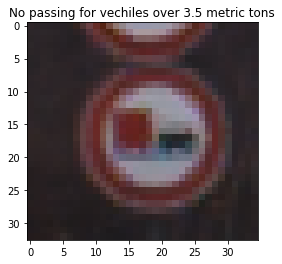

In [87]:
i = 560
plt.figure()
plt.imshow(trn_ds[i][0])
plt.title(trn_ds[i][1])

In [60]:
import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        #nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
    
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc

In [64]:
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

EPOCH: 1.000	trn_loss: 2.341	trn_acc: 0.313	val_loss: 1.402	val_acc: 0.544	(166.98s - 6512.19s remaining)
EPOCH: 2.000	trn_loss: 1.061	trn_acc: 0.651	val_loss: 0.907	val_acc: 0.704	(192.58s - 3659.00s remaining)
EPOCH: 3.000	trn_loss: 0.715	trn_acc: 0.763	val_loss: 0.733	val_acc: 0.759	(218.21s - 2691.21s remaining)
EPOCH: 4.000	trn_loss: 0.578	trn_acc: 0.810	val_loss: 0.564	val_acc: 0.816	(243.62s - 2192.56s remaining)
EPOCH: 5.000	trn_loss: 0.489	trn_acc: 0.838	val_loss: 0.504	val_acc: 0.833	(269.69s - 1887.83s remaining)
EPOCH: 6.000	trn_loss: 0.448	trn_acc: 0.853	val_loss: 0.498	val_acc: 0.840	(295.50s - 1674.49s remaining)
EPOCH: 7.000	trn_loss: 0.406	trn_acc: 0.867	val_loss: 0.420	val_acc: 0.862	(320.90s - 1512.81s remaining)
EPOCH: 8.000	trn_loss: 0.384	trn_acc: 0.877	val_loss: 0.436	val_acc: 0.859	(346.17s - 1384.69s remaining)
EPOCH: 9.000	trn_loss: 0.354	trn_acc: 0.885	val_loss: 0.410	val_acc: 0.871	(371.44s - 1279.41s remaining)
EPOCH: 10.000	trn_loss: 0.330	trn_acc: 0.891	v

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:03<00:00, 38.84it/s]


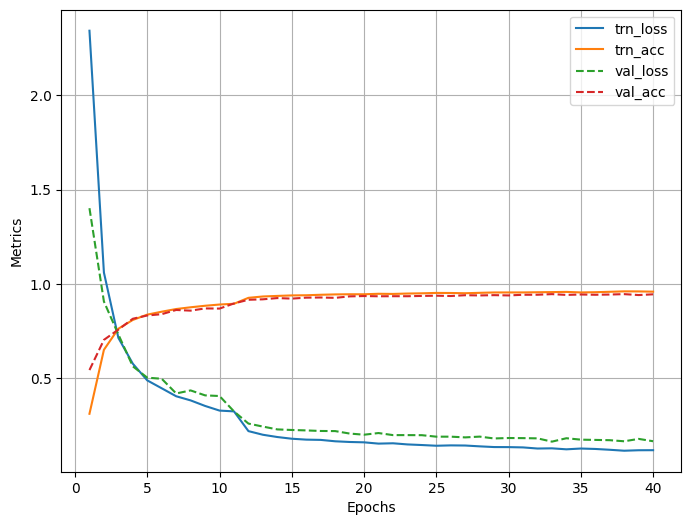

2021-11-07 11:55:17.339 | INFO     | __main__:<module>:22 - Dumped object of size ≈2 MB @ "no-aug-no-bn.log" in 1.87e+00 seconds


In [65]:
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-no-bn.log')

### Augmentation O / BatchNormalization X

2021-11-07 11:58:08.036 | INFO     | __main__:__init__:7 - 29406
2021-11-07 11:58:08.037 | INFO     | __main__:__init__:7 - 9803


EPOCH: 1.000	trn_loss: 2.801	trn_acc: 0.214	val_loss: 1.715	val_acc: 0.456	(38.83s - 1514.56s remaining)
EPOCH: 2.000	trn_loss: 1.507	trn_acc: 0.523	val_loss: 1.118	val_acc: 0.638	(77.62s - 1474.79s remaining)
EPOCH: 3.000	trn_loss: 1.093	trn_acc: 0.649	val_loss: 0.837	val_acc: 0.723	(116.57s - 1437.72s remaining)
EPOCH: 4.000	trn_loss: 0.896	trn_acc: 0.712	val_loss: 0.732	val_acc: 0.752	(157.24s - 1415.19s remaining)
EPOCH: 5.000	trn_loss: 0.800	trn_acc: 0.742	val_loss: 0.645	val_acc: 0.786	(196.96s - 1378.73s remaining)
EPOCH: 6.000	trn_loss: 0.709	trn_acc: 0.772	val_loss: 0.593	val_acc: 0.807	(237.00s - 1342.98s remaining)
EPOCH: 7.000	trn_loss: 0.651	trn_acc: 0.792	val_loss: 0.574	val_acc: 0.813	(276.84s - 1305.12s remaining)
EPOCH: 8.000	trn_loss: 0.618	trn_acc: 0.802	val_loss: 0.475	val_acc: 0.842	(316.87s - 1267.46s remaining)
EPOCH: 9.000	trn_loss: 0.590	trn_acc: 0.811	val_loss: 0.485	val_acc: 0.841	(356.75s - 1228.80s remaining)
EPOCH: 10.000	trn_loss: 0.562	trn_acc: 0.818	val

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:03<00:00, 37.59it/s]


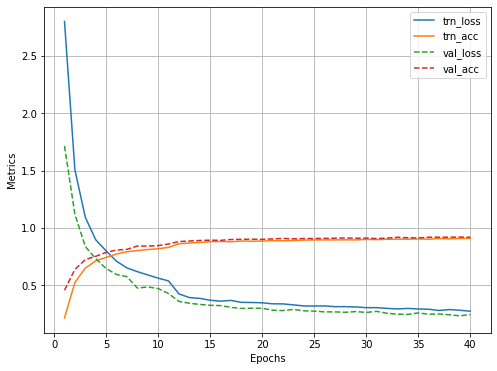

2021-11-07 12:24:42.916 | INFO     | __main__:<module>:85 - Dumped object of size ≈2 MB @ "yes-aug-no-bn.log" in 1.90e+00 seconds


In [88]:
trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ColorJitter(brightness=(0.8,1.2), 
    contrast=(0.8,1.2), 
    saturation=(0.8,1.2), 
    hue=0.25),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
#         nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
    
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
    
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'yes-aug-no-bn.log')

### Augmentation X / BatchNormalization O

2021-11-07 12:24:42.939 | INFO     | __main__:__init__:7 - 29406
2021-11-07 12:24:42.940 | INFO     | __main__:__init__:7 - 9803


EPOCH: 1.000	trn_loss: 1.415	trn_acc: 0.575	val_loss: 0.603	val_acc: 0.798	(26.06s - 1016.41s remaining)
EPOCH: 2.000	trn_loss: 0.438	trn_acc: 0.858	val_loss: 0.387	val_acc: 0.876	(51.99s - 987.89s remaining)
EPOCH: 3.000	trn_loss: 0.292	trn_acc: 0.904	val_loss: 0.278	val_acc: 0.907	(78.08s - 963.04s remaining)
EPOCH: 4.000	trn_loss: 0.237	trn_acc: 0.921	val_loss: 0.257	val_acc: 0.915	(104.15s - 937.35s remaining)
EPOCH: 5.000	trn_loss: 0.190	trn_acc: 0.937	val_loss: 0.199	val_acc: 0.934	(130.13s - 910.94s remaining)
EPOCH: 6.000	trn_loss: 0.163	trn_acc: 0.946	val_loss: 0.171	val_acc: 0.943	(156.24s - 885.37s remaining)
EPOCH: 7.000	trn_loss: 0.145	trn_acc: 0.953	val_loss: 0.181	val_acc: 0.943	(182.30s - 859.41s remaining)
EPOCH: 8.000	trn_loss: 0.131	trn_acc: 0.956	val_loss: 0.199	val_acc: 0.938	(208.34s - 833.35s remaining)
EPOCH: 9.000	trn_loss: 0.119	trn_acc: 0.960	val_loss: 0.148	val_acc: 0.954	(234.53s - 807.83s remaining)
EPOCH: 10.000	trn_loss: 0.107	trn_acc: 0.964	val_loss: 0.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:03<00:00, 40.29it/s]


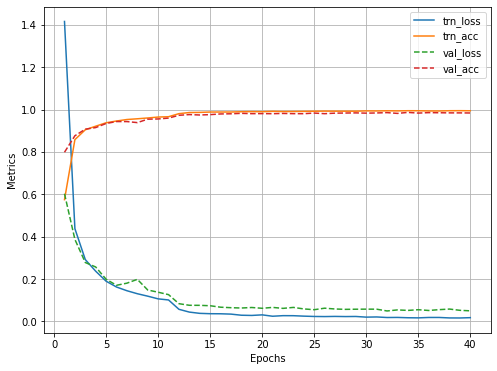

2021-11-07 12:41:59.167 | INFO     | __main__:<module>:85 - Dumped object of size ≈2 MB @ "no-aug-yes-bn.log" in 1.71e+00 seconds


In [89]:
trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    # T.ColorJitter(brightness=(0.8,1.2), 
    # contrast=(0.8,1.2), 
    # saturation=(0.8,1.2), 
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
    
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
    
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-yes-bn.log')

### Augmentation O / BatchNormalization O

2021-11-07 12:41:59.194 | INFO     | __main__:__init__:7 - 29406
2021-11-07 12:41:59.195 | INFO     | __main__:__init__:7 - 9803


EPOCH: 1.000	trn_loss: 1.893	trn_acc: 0.445	val_loss: 0.853	val_acc: 0.727	(39.43s - 1537.77s remaining)
EPOCH: 2.000	trn_loss: 0.738	trn_acc: 0.762	val_loss: 0.533	val_acc: 0.827	(78.91s - 1499.25s remaining)
EPOCH: 3.000	trn_loss: 0.521	trn_acc: 0.831	val_loss: 0.399	val_acc: 0.870	(118.38s - 1460.07s remaining)
EPOCH: 4.000	trn_loss: 0.422	trn_acc: 0.860	val_loss: 0.365	val_acc: 0.880	(157.86s - 1420.70s remaining)
EPOCH: 5.000	trn_loss: 0.368	trn_acc: 0.879	val_loss: 0.289	val_acc: 0.903	(197.40s - 1381.79s remaining)
EPOCH: 6.000	trn_loss: 0.318	trn_acc: 0.895	val_loss: 0.261	val_acc: 0.912	(236.87s - 1342.27s remaining)
EPOCH: 7.000	trn_loss: 0.284	trn_acc: 0.907	val_loss: 0.233	val_acc: 0.924	(276.28s - 1302.45s remaining)
EPOCH: 8.000	trn_loss: 0.260	trn_acc: 0.913	val_loss: 0.216	val_acc: 0.928	(315.74s - 1262.96s remaining)
EPOCH: 9.000	trn_loss: 0.244	trn_acc: 0.921	val_loss: 0.237	val_acc: 0.922	(355.23s - 1223.58s remaining)
EPOCH: 10.000	trn_loss: 0.220	trn_acc: 0.927	val

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:03<00:00, 38.87it/s]


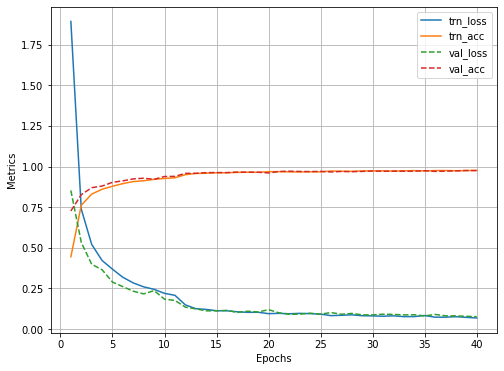

2021-11-07 13:08:25.673 | INFO     | __main__:<module>:85 - Dumped object of size ≈2 MB @ "yes-aug-yes-bn.log" in 1.85e+00 seconds


In [90]:
trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ColorJitter(brightness=(0.8,1.2), 
    contrast=(0.8,1.2), 
    saturation=(0.8,1.2), 
    hue=0.25),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
    
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
    
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'yes-aug-yes-bn.log')

2021-11-07 19:31:49.275 | INFO     | torch_snippets.paths:inner:24 - 4 files found at *.log



EPOCH: 20.000	trn_loss: 0.161	trn_acc: 0.946	val_loss: 0.202	val_acc: 0.936	(28568.02s - 28568.02s remaining)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 86.59it/s]


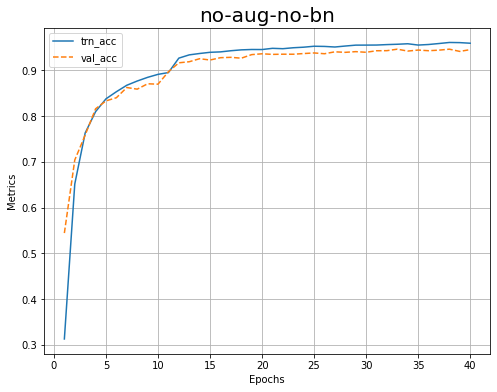



EPOCH: 20.000	trn_loss: 0.031	trn_acc: 0.990	val_loss: 0.062	val_acc: 0.981	(25628.39s - 25628.39s remaining)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 86.22it/s]


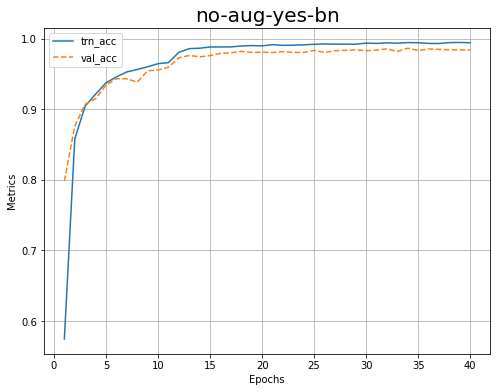



EPOCH: 20.000	trn_loss: 0.346	trn_acc: 0.885	val_loss: 0.299	val_acc: 0.900	(27225.25s - 27225.25s remaining)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 86.01it/s]


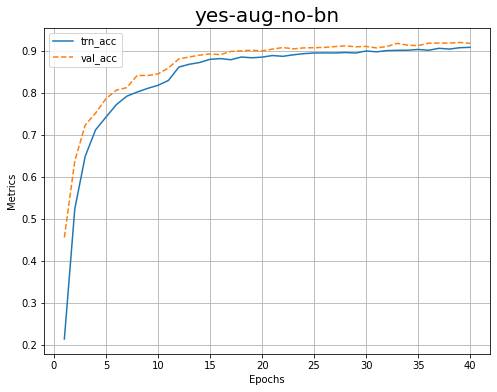



EPOCH: 20.000	trn_loss: 0.095	trn_acc: 0.969	val_loss: 0.119	val_acc: 0.961	(24596.10s - 24596.10s remaining)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 86.48it/s]


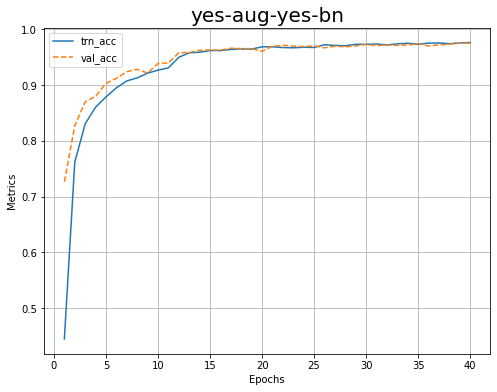

In [98]:
for f in Glob('*.log'):
    log = loaddill(f)
    print()
    log.report_avgs(20)
    log.plot_epochs(['trn_acc', 'val_acc'], title=fname(f).split('.')[0])
    print()
    line()